<a href="https://colab.research.google.com/github/SanandhKumar02/MiniProject_ProstateCancer/blob/main/R_ProstateCancer_DESeq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if (!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
BiocManager::install("TCGAbiolinks")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)

Installing package(s) 'BiocVersion', 'TCGAbiolinks'

also installing the dependencies ‘plogr’, ‘png’, ‘Biostrings’, ‘bitops’, ‘RSQLite’, ‘KEGGREST’, ‘filelock’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘AnnotationDbi’, ‘BiocFileCache’, ‘BiocGenerics’, ‘GenomeInfoDb’, ‘XVector’, ‘Rcpp’, ‘R.oo’, ‘R.methodsS3’, ‘MatrixGenerics’, ‘Biobase’, ‘DelayedArray’, ‘downloader’, ‘biomaRt’, ‘GenomicRanges’, ‘XML’, ‘plyr’, ‘IRanges’, ‘S4Vectors’, ‘R.utils’, ‘SummarizedExperiment’, ‘TCGAbiolinksGUI.data’


Old packages: 'blob', 'broom', 'haven', 'RColorBrewer', 'scales', 'vctrs'



In [ ]:
library(TCGAbiolinks)

In [ ]:
query <- GDCquery(project = "TCGA-PRAD", 
                  data.category = "Gene expression",
                  data.type = "Gene expression quantification",
                  experimental.strategy = "RNA-Seq",
                  platform = "Illumina HiSeq",
                  file.type = "results",
                  legacy = TRUE)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg19

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-PRAD

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By experimental.strategy

ooo By data.type

ooo By file.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



In [ ]:
GDCdownload(query, method = "api", files.per.chunk = 100,
            directory = "/content/Data")


GDCdownload will download 550 files. A total of 834.121914 MB




Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 61 MB     

Downloading: 30 MB     

In [ ]:
mrna_df <- GDCprepare(query, directory = "/content/Data")

--------------------

oo Reading 550 files

--------------------



|====================================================|100%                      Completed after 15 s 


--------------------

oo Merging 550 files

--------------------

Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

prad subtype information from:doi:10.1016/j.cell.2015.10.025



In [ ]:
mrna_meta <- mrna_df$sample

In [ ]:
mrna_meta <- cbind(mrna_meta, mrna_df$definition)

In [ ]:
BiocManager::install("SummarizedExperiment")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'SummarizedExperiment'”
Old packages: 'blob', 'broom', 'haven', 'RColorBrewer', 'scales', 'vctrs'



In [ ]:
library(SummarizedExperiment)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [ ]:
mrna_df <- assay(mrna_df)

In [ ]:
delim_fn = function(x, n, i){
    do.call(c, lapply(x, function(X)
        paste(unlist(strsplit(X, "-"))[(n+1):(i)], collapse = "-")))
}

In [ ]:
colnames(mrna_df) <- delim_fn(x = colnames(mrna_df), n = 0, i = 4)

In [ ]:
mrna_meta <- as.data.frame(mrna_meta)
mrna_df <- as.data.frame(mrna_df)

In [ ]:
metastatic_key <- mrna_meta[which(mrna_meta[,2] == "Metastatic"),]
mrna_meta <- mrna_meta[!mrna_meta[,2] == metastatic_key[,2],]
mrna_df <- mrna_df[, -grep(paste0(metastatic_key[,1]), colnames(mrna_df))]

In [ ]:
mrna_meta[,2] <- as.character(mrna_meta[,2])

In [ ]:
mrna_meta[,2] <- gsub("Primary solid Tumor", "Tumor", mrna_meta[,2])
mrna_meta[,2] <- gsub("Solid Tissue Normal", "Normal", mrna_meta[,2])
mrna_meta[,2] <- as.factor(mrna_meta[,2])
levels(mrna_meta[,2])
colnames(mrna_meta) <- c("cases", "Condition")

[1] "Normal" "Tumor"

In [ ]:
BiocManager::install("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)

Installing package(s) 'DESeq2'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘xtable’, ‘futile.logger’, ‘snow’, ‘BH’, ‘annotate’, ‘BiocParallel’, ‘genefilter’, ‘locfit’, ‘geneplotter’, ‘RcppArmadillo’


Old packages: 'blob', 'broom', 'haven', 'RColorBrewer', 'scales', 'vctrs'



In [ ]:
library(DESeq2)

In [ ]:
mrna_dds <- DESeqDataSetFromMatrix(round(mrna_df), colData = mrna_meta, design = ~ Condition)

converting counts to integer mode



In [ ]:
mrna_dds$Condition <- relevel(mrna_dds$Condition, ref = "Normal")

In [ ]:
mrna_dds <- DESeq(mrna_dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1439 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
resultsNames(mrna_dds)

[1] "Intercept"                 "Condition_Tumor_vs_Normal"

In [ ]:
mrna_res <- results(mrna_dds, alpha = 0.05, name = "Condition_Tumor_vs_Normal")

In [ ]:
summary(mrna_res)


out of 19669 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6423, 33%
LFC < 0 (down)     : 5957, 30%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [50]:
mrna_res_df <- as.data.frame(mrna_res)

In [ ]:
get_upregulated <- function(df){
    key <- intersect(rownames(df)[which(df$log2FoldChange>=1)],
              rownames(df)[which(df$pvalue<=0.05)])
    
    results <- as.data.frame((df)[which(rownames(df) %in% key),])
    return(results)
  }

In [ ]:
get_downregulated <- function(df){
  key <- intersect(rownames(df)[which(df$log2FoldChange<=-1)],
            rownames(df)[which(df$pvalue<=0.05)])
  
  results <- as.data.frame((df)[which(rownames(df) %in% key),])
  return(results)
}

In [ ]:
mrna_upreg <- get_upregulated(mrna_res)

In [ ]:
mrna_downreg <- get_downregulated(mrna_res)

In [ ]:
mrna_counts <- counts(mrna_dds, normalized = T)

In [ ]:
mrna_upreg$Gene_id <- rownames(mrna_upreg)

In [ ]:
mrna_downreg$Gene_id <- rownames(mrna_downreg)

In [54]:
write.table(mrna_counts, "/content/Results/mRNA_norm.counts.txt", quote = F, sep = "\t")

In [ ]:
write.table(mrna_upreg, "/content/Results/mRNA_upreg.txt", quote = F, sep = "\t", row.names = F)
write.table(mrna_downreg, "/content/Results/mRNA_downreg.txt", quote = F, sep = "\t", row.names = F)

In [49]:
par(mfrow=c(1,1))

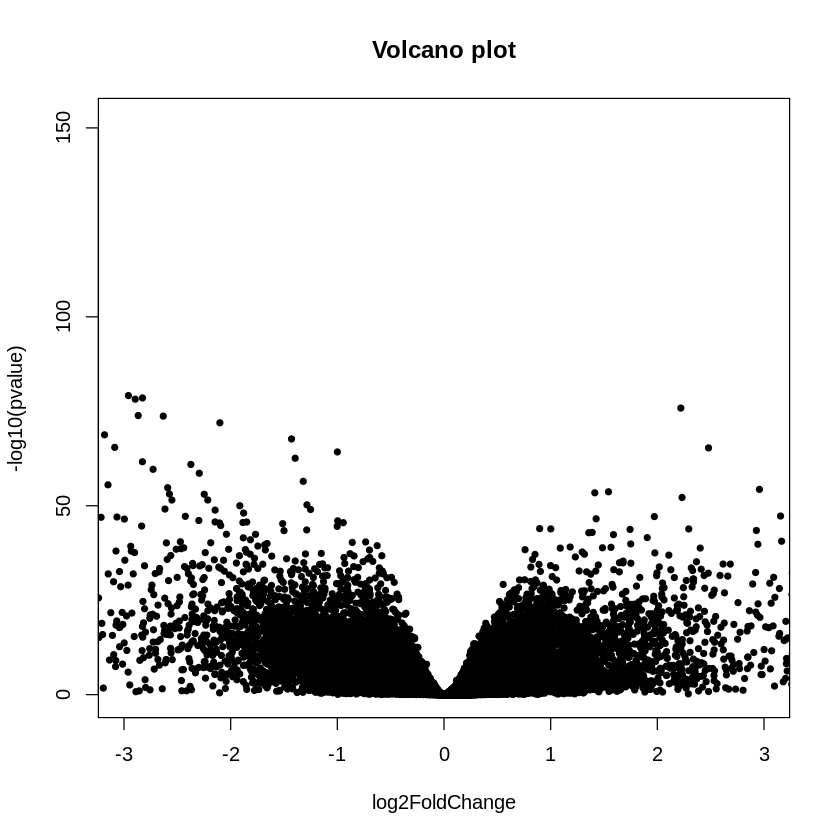

In [51]:
with(mrna_res_df, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))

In [53]:
with(subset(mrna_res_df, padj<0.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))

ERROR: ignored